In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import urllib #For webscraping
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import ComplementNB
from sklearn.svm import LinearSVC

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score

from sklearn.model_selection import GridSearchCV

# set plot style
sns.set()



In [2]:
# Read data in and view first few entries
df = pd.read_csv('train.csv')
df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


## Data Engineering
---
Prior to training a model with any sort of data, it is essential to re-engineer it. This is to ensure that the data is in a consistent form with no missing values, incorrect data types or just plain incorrect data. For structured,  numeric data, this entails scaling values, filling in missing values and typecasting any non-numeric data to numeric form. Non-numeric data, such as this database is often unstructured and consists of text data. This type of data is not easily interpretable by computers. Computers work with 1s and 0s, not letters and words. Therefore it must be converted into a form that is interpretable, and therefore, numeric data. 

### Text Cleaning -  Removing URLs

Many of the tweets in this dataset have URLs in them. For this project, we have decided to completely replace them with a consistent "url-web" token. Another option is to extract useful information from these links. One approach we tried was to extract the title of webpages in tweets and add them to the tweet text, this could potentially improve model quality, but there are several issues with this approach. Firstly, this dataset is a few years old, many of the URLs no longer exist, in addition to this, there appears to be an encoding issue with the some of the tweets which contain strange non-standard characters, when these characters occur in tweet URLs, this breaks it. 

---

Additionally, extracting information from URLs, aka webscraping, is a slow process. This dataset contains a few thousand URLs so to extract page titles from each URL a request needs to be sent, a response must be recieved and HTML data must be downloaded. Doing this a few times is not an issue but doing it a few thousand times takes a significant amount of time and data. It is possible to speed this process up by making it highly threaded, so that each URL isn't queryied sequentially, but this doesn't solve the problem entirely

In [3]:
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
df['message'] = df['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

The next step taken was to convert all capital letters to lowercase, and to remove all non-standard characters and punctuation. What remains in each tweet is now only lowercase letters, numbers and spaces.

In [4]:
df['message'] = df['message'].str.lower()

In [5]:
normal_chars = 'abcdefghijklmnopqrstuvwxyz0123456789 '
def remove_weird_chars(post):
    return ''.join([l for l in post if l in normal_chars])

In [6]:
df['message'] = df['message'].apply(remove_weird_chars)
df['message'].iloc[0]

'polyscimajor epa chief doesnt think carbon dioxide is main cause of global warming and wait what urlweb via mashable'

## Creating Features and labels datasets

In [7]:
X = df["message"]
y = df["sentiment"]

In [8]:
X.head()

0    polyscimajor epa chief doesnt think carbon dio...
1    its not like we lack evidence of anthropogenic...
2    rt rawstory researchers say we have three year...
3    todayinmaker wired  2016 was a pivotal year in...
4    rt soynoviodetodas its 2016 and a racist sexis...
Name: message, dtype: object

## Train, test split

When training a model, it is essential to set some data aside that will not be exposed to the model during the initial training process. This data is used after training to evaluate the trained model's performance. If this is not done, we have no way of knowing how our model will perform on unseen data. Will it be able to generalize well? Or has it just learnt to minimize errors on the training data (ie our model is overfitted). Below we split our features and labels into training and testing sets, with the testing set being 25% of the total data set and the training set being the other 75%.

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Vectorizing using Tfidf

The overall process of turning a collection of text data into numerical vectors is called vectorization. This process is often divided into 3 steps:

1.Tokenize text by assigning an ID to each possible token, often by using whitespace as a token separator

2.Count the number of times each token occurs in the document

3.Normalizing and redicing the weighting of tokens that occur very often in the corpus as these likely do not assist in model training

After vectorization, a corpus of strings or documents can be stored as a matrix, where a row corresponds to a document and a column corresponds to a particular token. This strategy outlined above is known as 'Bag of Words' representation as text data is stored purely as counts of word occurances, with word order not being a factor.

---

tf–idf, the vectorization method here stands for term-frequency times inverse document-frequency, and it was used because it helps minimize the importance of tokens that appear frequently in the corpus. 

In [10]:
vect = TfidfVectorizer(min_df=2, max_df=0.25, analyzer='char', ngram_range=(6,6))
vect.fit_transform(X_train)

<11864x91470 sparse matrix of type '<class 'numpy.float64'>'
	with 944852 stored elements in Compressed Sparse Row format>

In [11]:
pred_dict = {}

# Modelling

## Model 1: Complement Naive Bayes classifier

In [49]:
param_grid_cnb = {'alpha': [0.01, 0.05, 0.1,0.25,0.5,0.75,1]}

In [50]:
model = ComplementNB(alpha=0.1)

In [51]:
grid_CNB = GridSearchCV(ComplementNB(), param_grid_cnb, scoring='f1_weighted')

In [52]:
grid_CNB.fit(vect.transform(X_train), y_train)
grid_CNB.best_params_

{'alpha': 0.5}

In [32]:
cnb = ComplementNB(alpha=0.5)

In [33]:
cnb.fit(vect.transform(X_train), y_train)
y_pred = cnb.predict(vect.transform(X_test))
pred_dict['CNB'] = y_pred

In [34]:
cnb_report = metrics.classification_report(y_test, y_pred,digits=3)

## Model 2: Linear Support Vector Classifier

In [58]:
param_grid_lsvc = {'C': [0.1,0.25,0.5,0.75,1,1.25,1.5,1.75,2]}

In [59]:
grid_SVC = GridSearchCV(LinearSVC(), param_grid_lsvc, scoring='f1_weighted')

In [60]:
grid_SVC.fit(vect.transform(X_train), y_train)
grid_SVC.best_params_

{'C': 1.5}

In [51]:
svc = LinearSVC(C=1.5)

In [52]:
svc.fit(vect.transform(X_train), y_train)
y_pred = svc.predict(vect.transform(X_test))
pred_dict['LSVC'] = y_pred

In [53]:
svc_report = metrics.classification_report(y_test, y_pred,digits=3)

## Model 3: Multinomial Logistical Regression

In [24]:
param_grid_MLR = {'C': [0.75, 1, 1.25]}

In [25]:
grid_MLR = GridSearchCV(LogisticRegression(max_iter=10000), param_grid_MLR, scoring='f1_weighted')

In [27]:
#Grid search with different C values seems to get stuck. Don't run this cell
# grid_MLR.fit(vect.transform(X_train), y_train)
# grid_MLR.best_params_

In [55]:
mlr = LogisticRegression(C=1, max_iter=10000)

In [56]:
mlr.fit(vect.transform(X_train), y_train)
y_pred = mlr.predict(vect.transform(X_test))
pred_dict['MLR'] = y_pred

In [57]:
mlr_report = metrics.classification_report(y_test, y_pred,digits=3)

## Model Evaluation:

### Classification Reports for all three models

In [58]:
print('Complement Naive Bayes classifier:')
print(cnb_report)
print('Support Vector Classifier:')
print(svc_report)
print('Multinomial Logistical Regression:')
print(mlr_report)

Complement Naive Bayes classifier:
              precision    recall  f1-score   support

          -1      0.754     0.464     0.575       336
           0      0.629     0.360     0.458       547
           1      0.782     0.841     0.810      2178
           2      0.683     0.836     0.752       894

    accuracy                          0.741      3955
   macro avg      0.712     0.625     0.649      3955
weighted avg      0.736     0.741     0.728      3955

Support Vector Classifier:
              precision    recall  f1-score   support

          -1      0.816     0.500     0.620       336
           0      0.606     0.424     0.499       547
           1      0.785     0.885     0.832      2178
           2      0.774     0.789     0.781       894

    accuracy                          0.767      3955
   macro avg      0.745     0.649     0.683      3955
weighted avg      0.760     0.767     0.757      3955

Multinomial Logistical Regression:
              precision    recall

### Confusion Matricies

Shown below are the confusion matricies for the three models we fitted to the vectorized training data. Support Vector Classifiers

In [39]:
cm_cnb = confusion_matrix(y_test, pred_dict['CNB'])
cm_svc = confusion_matrix(y_test, pred_dict['LSVC'])
cm_mlr = confusion_matrix(y_test, pred_dict['MLR'])
labels = ['-1: Anti', '0: Neutral', '1: Pro', '2: News']

In [40]:
cm_cnb = cm_cnb/cm_cnb.sum(axis=1).reshape(-1, 1)
cm_svc = cm_svc/cm_svc.sum(axis=1).reshape(-1, 1)
cm_mlr = cm_mlr/cm_mlr.sum(axis=1).reshape(-1, 1)

Text(0.5, 1.0, 'Logisitc Regression')

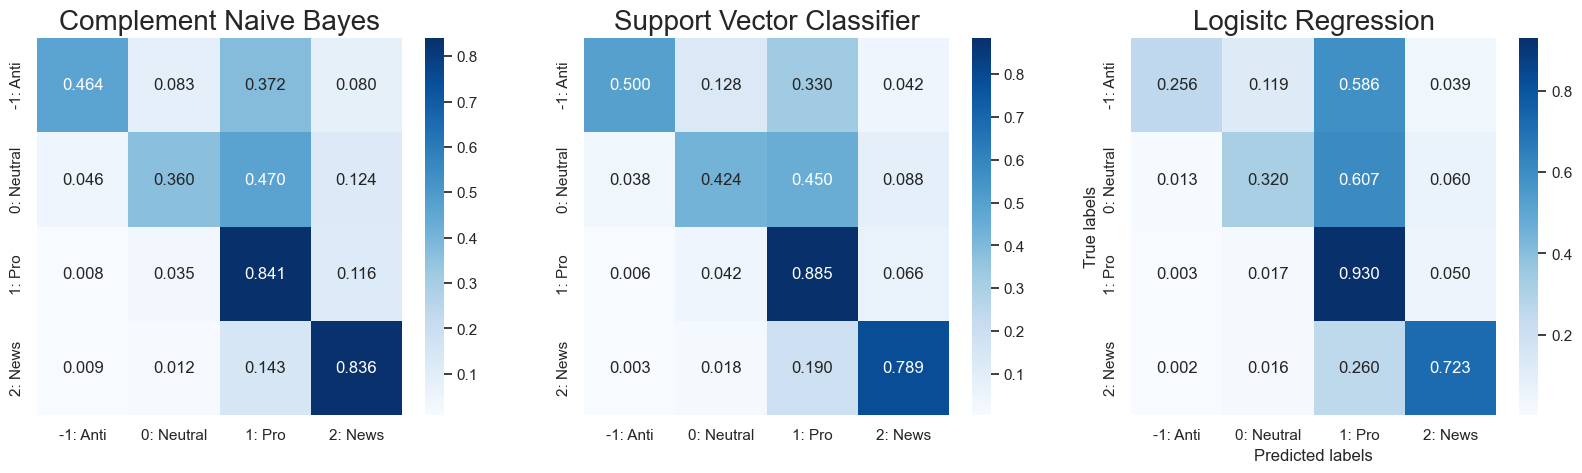

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5), dpi=100)
sns.heatmap(cm_cnb, annot=True, cmap='Blues', fmt='.3f', xticklabels=labels, yticklabels=labels, ax=axes[0])
sns.heatmap(cm_svc, annot=True, cmap='Blues', fmt='.3f', xticklabels=labels, yticklabels=labels, ax=axes[1])
sns.heatmap(cm_mlr, annot=True, cmap='Blues', fmt='.3f', xticklabels=labels, yticklabels=labels, ax=axes[2])
plt.ylabel("True labels")
plt.xlabel("Predicted labels")
axes[0].set_title(f"Complement Naive Bayes", fontsize=20)
axes[1].set_title(f"Support Vector Classifier", fontsize=20)
axes[2].set_title(f"Logisitc Regression", fontsize=20)